# Cool Front Image

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d

import pyvista as pv

from hnc.hnc.constants import *


In [46]:
gij_file = "results/CHNC_Al_rs2.998_TeV1.000.dat"
gij_data = read_csv(gij_file, delim_whitespace=True, header=3)
rs = 2.998 # AU
r_data, gei_data = gij_data['r/ri']*rs, gij_data['g_ei']

In [47]:
Al_MD_file = "results/Luciano_Al_checlpoint_10000.npz" 
MD_data = np.load(Al_MD_file)
MD_array = MD_data['pos']*cm_to_AU
MD_data

NpzFile 'results/Luciano_Al_checlpoint_10000.npz' with keys: pos, vel, rdf_hist, species_heat_flux, species_pressure_kin_tensor...

In [48]:
# Radial distribution function g_ei(r)
g_ei = interp1d(r_data, gei_data, fill_value='extrapolate', bounds_error=False)

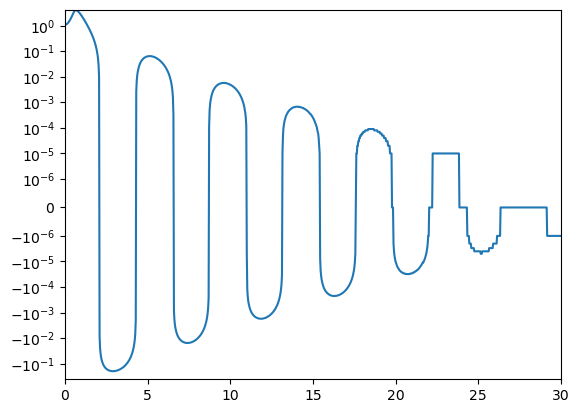

In [49]:
fig, ax = plt.subplots()

ax.plot(r_data, gei_data-1)
ax.set_xlim(0,30)
ax.set_yscale('symlog',linthresh=1e-6)

In [90]:
# Constants
L_simulation = 4.360647e-07*cm_to_AU
L = L_simulation # Define smaller box

# Define number of cells
correlation_distance = 6
N_cells_per_dim = int(L//correlation_distance)

# Make grid compatible with these cells with approximate dx
approx_dx = 0.15
Nx_approx = (L/approx_dx)
Nx = int(N_cells_per_dim*(Nx_approx//N_cells_per_dim))
dx = L/Nx
print("dx: ", dx)
# # Create a 3D grid

# Mesh grids for the entire domain (could be adjusted to only create necessary subcell meshes)
x = np.linspace(0, L_simulation, Nx)
y = np.linspace(0, L_simulation, Nx)
z = np.linspace(0, L_simulation, Nx)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# # Compute the electron density at each grid point
# electron_density = np.ones((Nx, Nx, Nx))

x_indices_list = np.array(np.split(np.arange(Nx),N_cells_per_dim)).astype(int)
subcell_L = x[x_indices_list[0,-1]] - x[x_indices_list[0,0]]
# Ion positions: Nx3 matrix
# Example positions, replace with your actual data
ion_positions = MD_array 
ion_cell_indices = np.floor(ion_positions/subcell_L) 

dx:  0.15092359992987164


In [95]:
%%time

def get_all_nearby_ions(subcell_indices):    
    shift_Xi  = np.meshgrid( np.arange(-1,2),np.arange(-1,2), np.arange(-1,2), indexing='ij' )
    adjacent_indices = (np.vstack([Xi.ravel() for Xi in shift_Xi]).T + subcell_indices)%N_cells_per_dim
    adjacent_ion_indices = []
    for index in adjacent_indices:
        adjacent_ion_indices += list(np.where(np.all(ion_cell_indices == index, axis=1))[0])
    
    return adjacent_ion_indices


def min_image_dist(p1, p2, L):
    """ Calculate the minimum image distance accounting for periodic boundary conditions """
    return np.abs(p1 - p2) - L * np.round(np.abs(p1 - p2) / L)


xi_slice = lambda i: slice(x_indices_list[i][0], x_indices_list[i][-1] + 1  ) 
slices = lambda xi, yi, zi: (xi_slice(xi), xi_slice(yi), xi_slice(zi) )

class SubCell():
    def __init__(self, cell_position, x_indices_list, cell_mesh, L_full_cell, ion_indices):
        self.cell_position = cell_position
        self.X, self.Y, self.Z = cell_mesh
        self.Nx = len(self.X)
        self.L_full_cell = L_full_cell
        self.ion_indices = ion_indices
        
    def set_density(self, density_array):
        grid_points = np.column_stack([self.X.ravel(), self.Y.ravel(), self.Z.ravel()])
        for ion_index in self.ion_indices:
            ion_pos = ion_positions[ion_index]
            min_image_distances = np.array([min_image_dist(grid_points[:, i], ion_pos[i], self.L_full_cell) for i in range(3)]).T
            distances = np.linalg.norm(min_image_distances, axis=1)
            subcell_density = g_ei(distances).reshape((self.Nx, self.Nx, self.Nx))
            density_array[slices(*self.cell_position)] *= subcell_density

electron_density = np.ones((Nx, Nx, Nx))
rendered_ion_positions = []
# Instantiate subcells and calcuate density
for ix in range(N_cells_per_dim):
    for iy in range(N_cells_per_dim):
        for iz in range(N_cells_per_dim):
            nearby_ion_indices = get_all_nearby_ions( (ix,iy,iz) )
            cell_mesh = X[slices(ix,iy,iz)], Y[slices(ix,iy,iz)], Z[slices(ix,iy,iz)]
            subcell = SubCell( (ix,iy,iz), x_indices_list, cell_mesh, L_simulation, nearby_ion_indices  )
            # X[slices(ix,iy,iz)].shape
            subcell.set_density(electron_density) 
            for ion_indices in nearby_ion_indices:
                rendered_ion_positions.append(ion_positions[ion_indices])
# ion_positions[3942], subcell_L

CPU times: user 5min 50s, sys: 239 ms, total: 5min 50s
Wall time: 5min 50s


In [96]:
# Create a point cloud with ion positions
unique_rendered_ion_positions = np.unique(rendered_ion_positions, axis=0)
print(f"{len(unique_rendered_ion_positions)} number of ions in corner")
points = pv.PolyData(unique_rendered_ion_positions)

# Save to a VTK file
points.save("ion_positions.vtk")

4674 number of ions in corner


In [101]:

# Example path data: an array of positions (x, y, z) over time
# Replace this with your actual time-sequence position data
traj_data = np.array(np.load("/home/zach/plasma/hnc/TCCW/Final_TCCW/Al1_single_particle_TS.npz")['arr_0'])*cm_to_AU
traj_data[0:100]
# traj_ion_index = 3942
# path_data = np.array([
#     MD_array[traj_ion_index],
#     MD_array[traj_ion_index]*[1.1,1.3,1],
#     MD_array[traj_ion_index]*[1.1,1.2,1],
#     MD_array[traj_ion_index]*[1.4,1.4,0.8],
#     MD_array[traj_ion_index]*[1.3,1.5,0.7]
# ])

# # Create a line representing the path
# path = pv.lines_from_points(traj_data)

# # Save to a VTK file
# path.save("particle_path.vtk")

array([[ 1.54453109,  1.08081696,  1.45989478],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 3.51017935, 31.73244552, 32.18346841],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 3.85760474, 31.77598294, 32.372

In [98]:
# Create a PyVista ImageData object
grid = pv.ImageData()

# Set the dimensions, spacing, and origin of the grid
grid.dimensions = np.array(electron_density.shape) + 1
grid.spacing = (L / (Nx - 1), L / (Nx - 1), L / (Nx - 1))
grid.origin = (0, 0, 0)

# Assign the electron density data to the grid
grid.cell_data["Electron Density"] = electron_density.flatten(order="F")  # Use Fortran order for compatibility with VTK
# grid.cell_data["values"] = values.flatten(order="F")
# grid
# Save the grid to a VTK file
grid.save("electron_density.vtk")
